In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from IPython.display import display
from pprint import pprint
import os
import sys

# brainbox / iblatlas / ONE 관련
from brainbox.io.one import SessionLoader, SpikeSortingLoader
from brainbox.singlecell import bin_spikes
from iblatlas.atlas import AllenAtlas
from one.api import ONE


BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
print(f"BASE_DIR: {BASE_DIR}")

RESULT_DIR = os.path.join(BASE_DIR, 'result', 'VISp', 'lateralization')

def add_module_paths(base, *rel_paths):
    for rel_path in rel_paths:
        sys.path.append(os.path.join(base, *rel_path))

add_module_paths(BASE_DIR,
    ['func'],               # func 바로 아래 함수들
    ['func', 'compute'],
    ['func', 'info'],
    ['func', 'plot']
)

from print_cluster_info import print_cluster_info
from get_trial_masks import get_trial_masks
from compute_raster import compute_raster
from plot_raster import plot_raster
from plot_psth_2x2 import plot_psth_2x2
from plot_psth_contrast import plot_psth_contrast
from plot_psth_1 import plot_psth_left_vs_right
from sub_func import save_file


BASE_DIR: c:\Users\miasc\SCH\shinlab\IBL\VISp_PSTH


In [ ]:
# -----------------------------------------------------------------------------
# 1. ONE 초기화 및 세션 검색(유연한 brain_acronym)
# -----------------------------------------------------------------------------
# 원하는 뇌영역 문자열을 지정(예: 'VISp', 'MOs' 등)
brain_acronym = 'VISp' 

one = ONE()
sessions = one.search(atlas_acronym=brain_acronym, query_type='remote')
print(f"\n[{brain_acronym}] No. of detected sessions: {len(sessions)} \nExample 5 sessions:")
pprint(sessions[:5])



[VISl] No. of detected sessions: 15 
Example 5 sessions:
['d901aff5-2250-467a-b4a1-0cb9729df9e2',
 'a405053a-eb13-4aa4-850c-5a337e5dc7fd',
 '35ed605c-1a1a-47b1-86ff-2b56144f55af',
 '872ce8ff-9fb3-485c-be00-bc5479e0095b',
 '872ce8ff-9fb3-485c-be00-bc5479e0095b']


In [3]:
eid = 'ca4ecb4c-4b60-4723-9b9e-2c54a6290a53'
pid = one.eid2pid(eid)[0][0]

# -----------------------------------------------------------------------------
# 2. Trial / Spike data 로드 (SessionLoader, SpikeSortingLoader)
# -----------------------------------------------------------------------------
# Trial 데이터
sl = SessionLoader(eid=eid, one=one)
sl.load_trials()
events = sl.trials['stimOn_times'].values
left_idx, right_idx, correct_idx, incorrect_idx = get_trial_masks(sl.trials) # trial mask

# Spike Sorting 데이터
ssl = SpikeSortingLoader(one=one, pid=pid, atlas=AllenAtlas())
spikes, clusters, channels = ssl.load_spike_sorting()
clusters = ssl.merge_clusters(spikes, clusters, channels)

c:\Users\miasc\anaconda3\envs\iblenv\lib\site-packages\one\util.py:521: ALFWarning: No default revision for dataset alf/probe00/pykilosort/#2024-03-22#/spikes.amps.npy; using most recent
  warnings.warn(
c:\Users\miasc\anaconda3\envs\iblenv\lib\site-packages\one\util.py:521: ALFWarning: No default revision for dataset alf/probe00/pykilosort/#2024-03-22#/spikes.clusters.npy; using most recent
  warnings.warn(
c:\Users\miasc\anaconda3\envs\iblenv\lib\site-packages\one\util.py:521: ALFWarning: No default revision for dataset alf/probe00/pykilosort/#2024-03-22#/spikes.depths.npy; using most recent
  warnings.warn(
c:\Users\miasc\anaconda3\envs\iblenv\lib\site-packages\one\util.py:521: ALFWarning: No default revision for dataset alf/probe00/pykilosort/#2024-03-22#/spikes.times.npy; using most recent
  warnings.warn(
c:\Users\miasc\anaconda3\envs\iblenv\lib\site-packages\one\util.py:521: ALFWarning: No default revision for dataset alf/probe00/pykilosort/#2024-03-22#/clusters.channels.npy; us

In [4]:
# clusters['acronym']의 값의 중복 제거 및 출력
print(f"\n[{brain_acronym}] No. of clusters: {len(clusters)}")
unique_acronyms = np.unique(clusters['acronym'])
print(f"\n[{brain_acronym}] Unique acronyms: {unique_acronyms}")



[VISp] No. of clusters: 34

[VISp] Unique acronyms: ['DG-mo' 'MB' 'MRN' 'ProS' 'RN' 'SCig' 'SCiw' 'SUB' 'VISp1' 'VISp2/3'
 'VISp4' 'VISp5' 'VISp6a' 'VISp6b' 'alv' 'dhc' 'fp' 'or' 'void']


In [5]:
# -----------------------------------------------------------------------------
# 3. 특정 영역(문자열 포함) Mask 정의 (모든 + good)
# -----------------------------------------------------------------------------
VISp_region_mask = np.array([brain_acronym in acr for acr in clusters['acronym']]) # ex) 'VISp1', 'VISp2', ...

# VISp1, VISp2/3, VISp4, VISp5, VISp6 등의 개별 영역을 포함하는 마스크
VISp1_mask = np.array(['VISp1' in acr for acr in clusters['acronym']])
VISp2_3_mask = np.array(['VISp2/3' in acr for acr in clusters['acronym']])
VISp4_mask = np.array(['VISp4' in acr for acr in clusters['acronym']])
VISp5_mask = np.array(['VISp5' in acr for acr in clusters['acronym']])
VISp6a_mask = np.array(['VISp6a' in acr for acr in clusters['acronym']])
VISp6b_mask = np.array(['VISp6b' in acr for acr in clusters['acronym']])

# --------------------------------------------------------
# ---------------------
good_mask = (clusters['label'] == 1)

# 모든 영역 마스크에 good_mask 적용
for mask in [VISp_region_mask, VISp1_mask, VISp2_3_mask, VISp4_mask, VISp5_mask, VISp6a_mask, VISp6b_mask]:
    mask = mask & good_mask  # Ensure all masks are good clusters
# -----------------------------------------------------------------------------

clusters_good = {k: v[good_mask] for k, v in clusters.items()} # Good clusters만 추출

print_cluster_info(clusters, clusters_good, brain_acronym)



No. of clusters in the session (good | all): [136 | 1117]

No. of clusters in each region:
DG-mo: 0 | 2
MB: 5 | 26
MRN: 14 | 106
ProS: 36 | 247
RN: 17 | 184
SCig: 8 | 108
SCiw: 5 | 78
SUB: 8 | 92
VISp1: 1 | 30
VISp2/3: 7 | 83
VISp4: 6 | 25
VISp5: 19 | 58
VISp6a: 5 | 23
VISp6b: 2 | 13
alv: 0 | 1
dhc: 1 | 13
fp: 1 | 9
or: 1 | 12
void: 0 | 7

No. of clusters in VISp (good | all): [40 | 232]



>> [VISp] : 232 Single Cluster found.

>> [VISp] : 232 Good Clusters found.

>> [VISp1] : 30 Good Clusters found.

>> [VISp2_3] : 83 Good Clusters found.

>> [VISp4] : 25 Good Clusters found.

>> [VISp5] : 58 Good Clusters found.

>> [VISp6a] : 23 Good Clusters found.

>> [VISp6b] : 13 Good Clusters found.


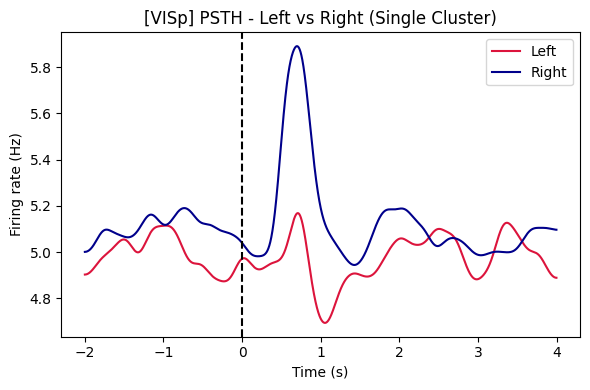

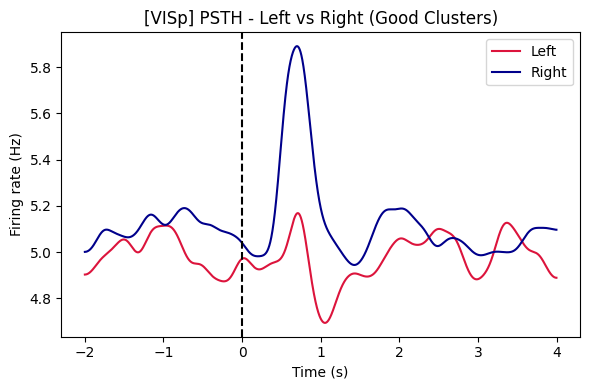

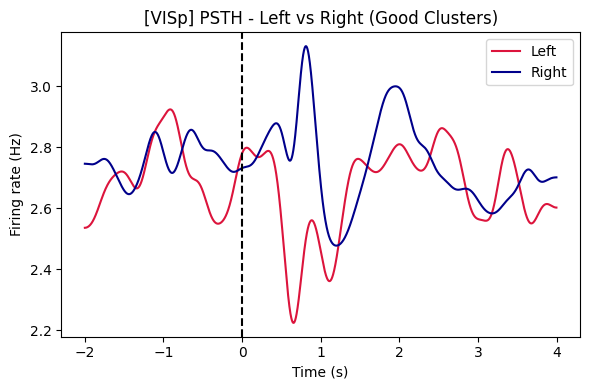

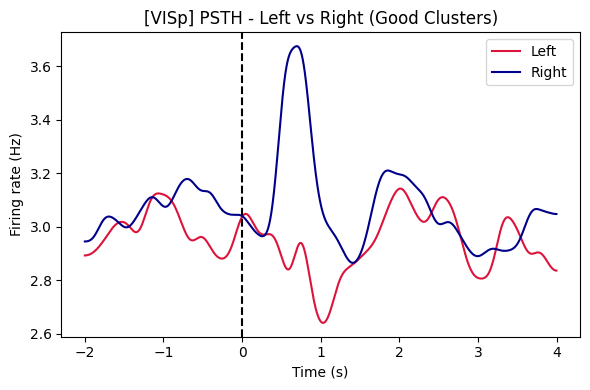

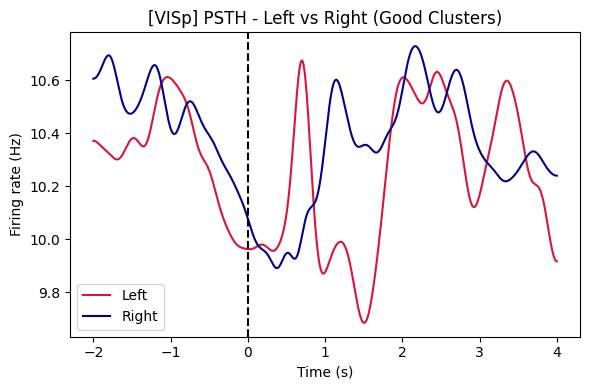

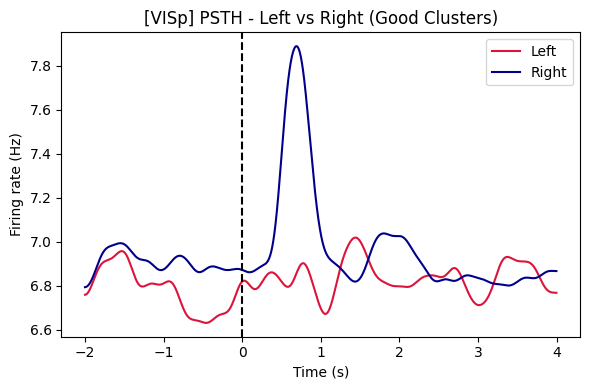

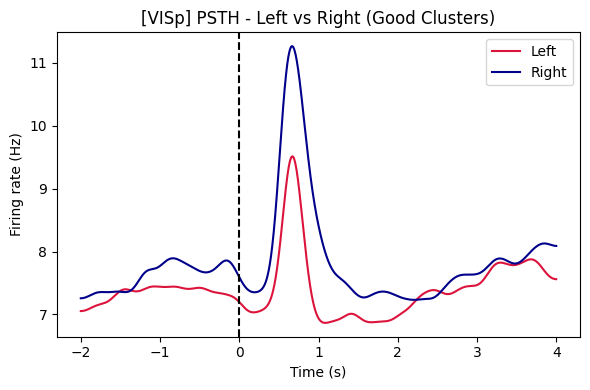

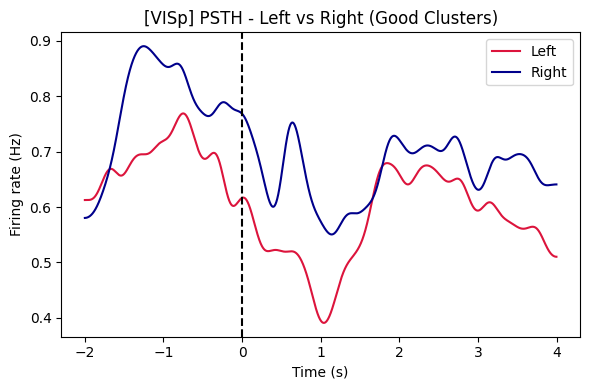

Done.


In [6]:
# -----------------------------------------------------------------------------
# 6. 두 가지 경우(모든 클러스터 / good 클러스터)에 대해 동일한 분석
# -----------------------------------------------------------------------------
for brain_region, cluster_label, selected_mask in [("VISp", "Single Cluster", VISp_region_mask),
                                ("VISp", "Good Clusters", VISp_region_mask),
                                ("VISp1", "Good Clusters", VISp1_mask),
                                ("VISp2_3", "Good Clusters", VISp2_3_mask),
                                ("VISp4", "Good Clusters", VISp4_mask),
                                ("VISp5", "Good Clusters", VISp5_mask),
                                ("VISp6a", "Good Clusters", VISp6a_mask),
                                ("VISp6b", "Good Clusters", VISp6b_mask)]:
    
    selected_cluster_ids = np.where(selected_mask)[0] # 해당되는 클러스터 ID들
    if cluster_label == "Single Clsuter":
        selected_cluster_ids = [selected_cluster_ids[0]]
        n_clusters = 1
    else:
        n_clusters = len(selected_cluster_ids)
        if n_clusters == 0:
            print(f"No {cluster_label.lower()} in '{brain_region}' region. Skip.")
            continue
    
    print(f"\n>> [{brain_region}] : {n_clusters} {cluster_label} found.")
    
    spike_raster, times = compute_raster(spikes, selected_cluster_ids, events, pre_time=2, post_time=4, bin_size=0.001)

    #plot_raster(spike_raster, times, events, brain_region, cluster_label, RESULT_DIR)
    #plot_psth_2x2(spike_raster, times, left_idx, right_idx, correct_idx, incorrect_idx, brain_region, cluster_label, RESULT_DIR)
    #plot_psth_contrast(spike_raster, times, sl.trials, left_idx, right_idx, brain_region, cluster_label, RESULT_DIR)
    plot_psth_left_vs_right(spike_raster, times, left_idx, right_idx, brain_acronym, cluster_label, RESULT_DIR)

plt.show(block=False) 
plt.close('all')
print("Done.")